In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

from sklearn.decomposition import PCA

2024-08-23 16:52:04.701585: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-23 16:52:05.245779: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
folder_path = '/mnt/home/tudomlumleart/ceph/08_SedonaDataset'

In [53]:
dataset_path = os.path.join(folder_path, 'fig5_data_brain_esc_npc.mat')

In [54]:
dataset = scipy.io.loadmat(dataset_path)

In [55]:
dataset.keys()

dict_keys(['__header__', '__version__', '__globals__', 'brainMap1', 'brainMap2', 'brainPoly1', 'brainPoly2', 'brain_bH', 'esc1_maps', 'esc1_polys', 'esc2_maps', 'esc2_polys', 'npc1_maps', 'npc1_polys', 'npc2_maps', 'npc2_polys', 'npc_bH'])

In [56]:
brain_poly1 = dataset['brainPoly1']
brain_poly2 = dataset['brainPoly2']
esc_poly1 = dataset['esc1_polys']
esc_poly2 = dataset['esc2_polys']
npc_poly1 = dataset['npc1_polys']
npc_poly2 = dataset['npc2_polys']

In [57]:
brain_poly1.shape

(54, 3, 12333)

In [14]:
def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys


In [59]:
brain_poly1 = interpolate_polymers(brain_poly1)
brain_poly2 = interpolate_polymers(brain_poly2)
esc_poly1 = interpolate_polymers(esc_poly1)
esc_poly2 = interpolate_polymers(esc_poly2)
npc_poly1 = interpolate_polymers(npc_poly1)
npc_poly2 = interpolate_polymers(npc_poly2)

In [15]:
def generate_distance_maps(polys):
    num_probes, num_coords, num_cells = polys.shape
    return np.array([squareform(pdist(polys[:, :, c])) for c in range(num_cells)])

In [61]:
brain_map1 = generate_distance_maps(brain_poly1)
brain_map2 = generate_distance_maps(brain_poly2)
esc_map1 = generate_distance_maps(esc_poly1)
esc_map2 = generate_distance_maps(esc_poly2)
npc_map1 = generate_distance_maps(npc_poly1)
npc_map2 = generate_distance_maps(npc_poly2)

In [62]:
brain_map = np.concatenate([brain_map1, brain_map2], axis=0)
esc_map = np.concatenate([esc_map1, esc_map2], axis=0)
npc_map = np.concatenate([npc_map1, npc_map2], axis=0)

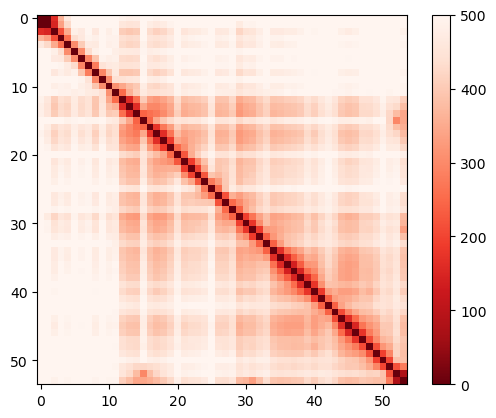

In [63]:
# Plot median map
plt.imshow(np.median(brain_map, axis=0), cmap='Reds_r', vmax=500)
plt.colorbar()

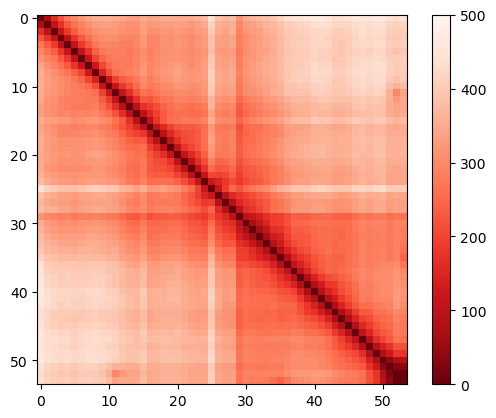

In [64]:
plt.imshow(np.median(esc_map, axis=0), cmap='Reds_r', vmax=500)
plt.colorbar()

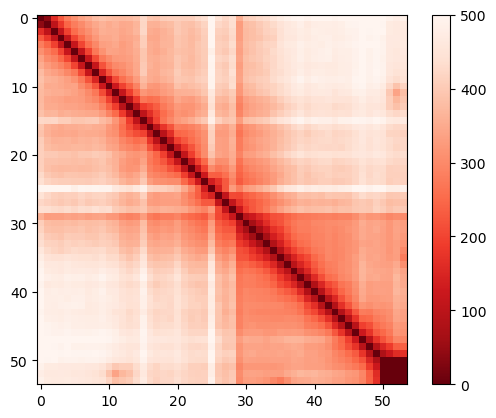

In [65]:
plt.imshow(np.median(npc_map, axis=0), cmap='Reds_r', vmax=500)
plt.colorbar()

In [66]:
# Flatten all maps 
# brain_map_flat = np.array([x.flatten() for x in brain_map])
esc_map_flat = np.array([x.flatten() for x in esc_map])
npc_map_flat = np.array([x.flatten() for x in npc_map])

In [67]:
all_map_flat = np.concatenate([esc_map_flat, npc_map_flat], axis=0)

In [68]:
pca = PCA(n_components=2)
pca.fit(all_map_flat)
esc_map_pca = pca.transform(esc_map_flat)
npc_map_pca = pca.transform(npc_map_flat)
# brain_map_pca = pca.transform(brain_map_flat)

In [69]:
# Convert the PC into a dataframe
esc_df = pd.DataFrame(esc_map_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
npc_df = pd.DataFrame(npc_map_pca, columns=['PC1', 'PC2'])
npc_df['label'] = 'NPC'
# brain_df = pd.DataFrame(brain_map_pca, columns=['PC1', 'PC2'])
# brain_df['label'] = 'Brain'

In [70]:
all_df = pd.concat([esc_df, npc_df], axis=0)

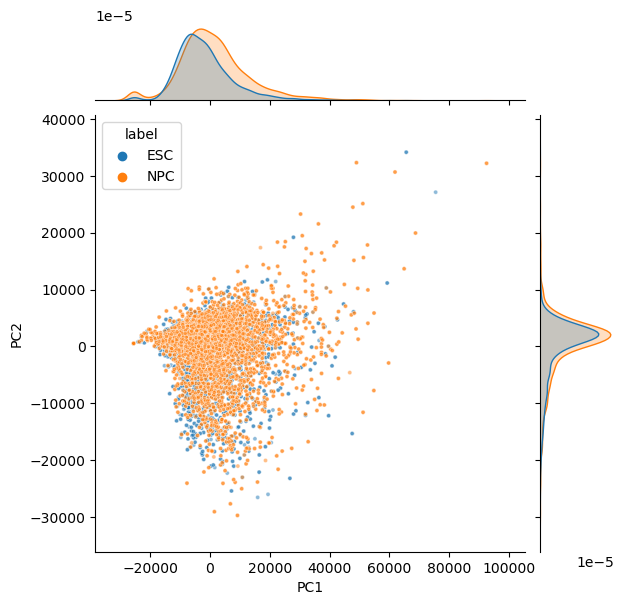

In [71]:
sns.jointplot(x='PC1', y='PC2', data=all_df, marker='.', hue='label', alpha=0.5)

In [72]:
# Find 0.05 and 0.95 quantiles of PC1 and PC2 data
l = 0.01
u = 1-0.01

pc1_l = all_df['PC1'].quantile(l)
pc1_u = all_df['PC1'].quantile(u)
pc2_l = all_df['PC2'].quantile(l)
pc2_u = all_df['PC2'].quantile(u)

pc1_grid = np.linspace(pc1_l, pc1_u, 50)
pc2_grid = np.linspace(pc2_l, pc2_u, 50)

# Generate combination of pc1 and pc2 values
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

# put this into a dataframe
pc1_grid_flat = pc1_grid.flatten()
pc2_grid_flat = pc2_grid.flatten()
pc1_pc2_df = pd.DataFrame({'PC1': pc1_grid_flat, 'PC2': pc2_grid_flat})
pc1_pc2_df['label'] = 'metastructures'

In [73]:
# Sort PC2 in descending order while keeping PC1 in ascending order
pc1_pc2_df = pc1_pc2_df.sort_values(by=['PC1', 'PC2'], ascending=[True, False], ignore_index=True)
metastr_from_pca = pca.inverse_transform(pc1_pc2_df[['PC1', 'PC2']])

In [16]:
def load_weights(directory, num_metastructures):
    log_weights = []
    lp = []
    files = sorted(os.listdir(directory))[-4:]
    print(files)
    
    log_weights_d = []
    for file in files:
        log_weights_chain = []
        lp_chain = []
        with open('%s/%s'%(directory, file), newline='') as csvfile:
            reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), )
            for row in reader:
                log_weights_row = [float(row["log_weights.%d"%i]) for i in range(1,num_metastructures+1)]
                lp_chain.append(float(row["lp__"]))
                log_weights_chain.append(log_weights_row)
        log_weights = np.array(log_weights_chain)
        lp_chain = np.array(lp_chain)
        log_weights_d.append(log_weights)
        lp.append(lp_chain)
    log_weights_d = np.array(log_weights_d)
    return log_weights_d 

In [75]:
common_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20240822_WeightMCMC_ESC_NPC'

stan_directory_esc = os.path.join(common_dir, 'ESC/stan_output')
stan_directory_npc = os.path.join(common_dir, 'NPC/stan_output')

esc_log_weights = load_weights(stan_directory_esc, 2500)
npc_log_weights = load_weights(stan_directory_npc, 2500)

['20240715_WeightOptimization-20240822154408_1.csv', '20240715_WeightOptimization-20240822154408_2.csv', '20240715_WeightOptimization-20240822154408_3.csv', '20240715_WeightOptimization-20240822154408_4.csv']
['20240715_WeightOptimization-20240822160637_1.csv', '20240715_WeightOptimization-20240822160637_2.csv', '20240715_WeightOptimization-20240822160637_3.csv', '20240715_WeightOptimization-20240822160637_4.csv']


In [76]:
esc_weights_all = np.exp(np.array(esc_log_weights))
npc_weights_all = np.exp(np.array(npc_log_weights))

In [77]:
esc_weights_all.shape

(4, 1000, 2500)

In [78]:
esc_weights = np.mean(np.exp(np.array(esc_log_weights)), axis=(0, 1))
npc_weights = np.mean(np.exp(np.array(npc_log_weights)), axis=(0, 1))

# Put weights in a DataFrame
esc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                               'PC2': pc1_pc2_df['PC2'].values,  
                               'weight': esc_weights})
esc_weights_df['label'] = 'ESC'
npc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                               'PC2': pc1_pc2_df['PC2'].values, 
                               'weight': npc_weights})
npc_weights_df['label'] = 'NPC'

In [79]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240822'

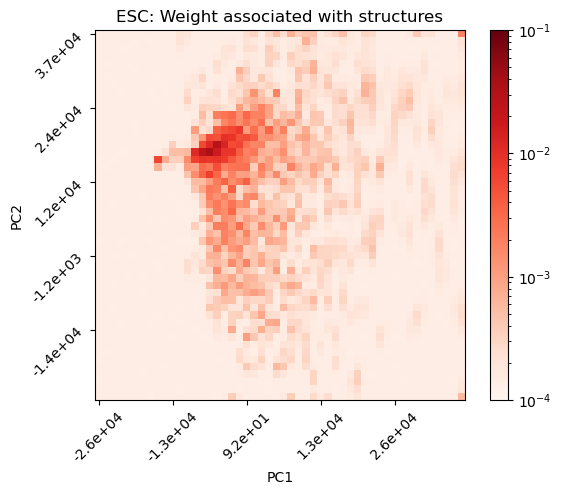

In [80]:
from matplotlib.colors import LogNorm
vmin = 1E-4
vmax = 1E-1

plt.imshow(esc_weights_df['weight'].values.reshape(50, 50).T,
           cmap='Reds', norm=LogNorm(vmin=vmin, vmax=vmax))
# set xticks 
xlabel = np.array([f"{x:.1e}" for x in esc_weights_df['PC1'].unique()])[::10]
ylabel = np.array([f"{x:.1e}" for x in esc_weights_df['PC2'].unique()])[::-10]
plt.xticks(np.arange(0, 50, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 50, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ESC: Weight associated with structures')
plt.colorbar()
plt.savefig(os.path.join(save_dir, 'SD_esc_weights_50x50.png'), dpi=300, bbox_inches='tight')


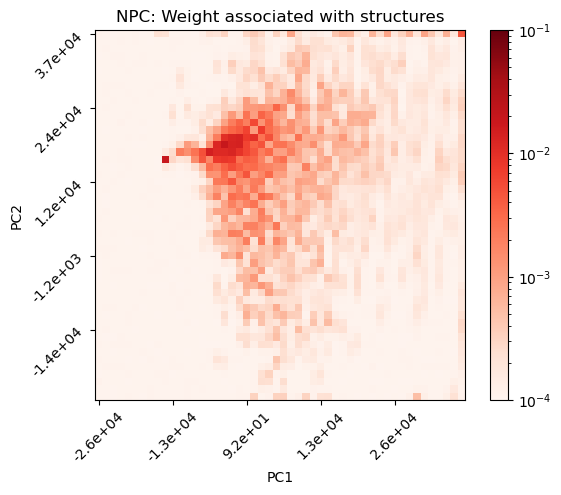

In [81]:
vmin = 1E-4
vmax = 1E-1

plt.imshow(npc_weights_df['weight'].values.reshape(50, 50).T,
           cmap='Reds', norm=LogNorm(vmin=vmin, vmax=vmax))
# set xticks 
xlabel = np.array([f"{x:.1e}" for x in esc_weights_df['PC1'].unique()])[::10]
ylabel = np.array([f"{x:.1e}" for x in esc_weights_df['PC2'].unique()])[::-10]
plt.xticks(np.arange(0, 50, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 50, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('NPC: Weight associated with structures')
plt.colorbar()
plt.savefig(os.path.join(save_dir, 'SD_npc_weights_50x50.png'), dpi=300, bbox_inches='tight')


In [82]:
esc_weight_table = esc_weights_df['weight'].values.reshape(50, 50).T
npc_weight_table = npc_weights_df['weight'].values.reshape(50, 50).T

diff_table = npc_weight_table / esc_weight_table

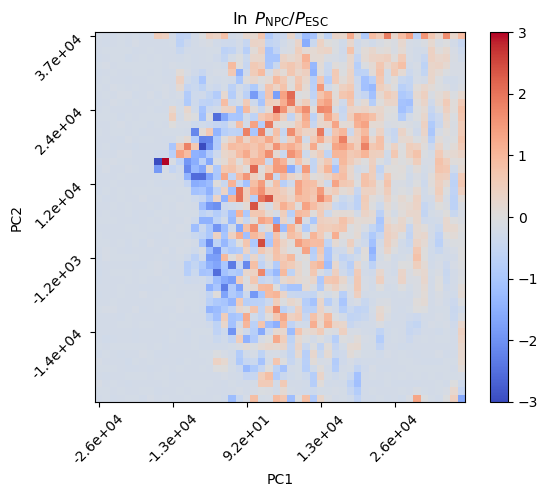

In [83]:
plt.imshow(np.log(diff_table), cmap='coolwarm', vmin=-3, vmax=3)
plt.colorbar()
xlabel = np.array([f"{x:.1e}" for x in esc_weights_df['PC1'].unique()])[::10]
ylabel = np.array([f"{x:.1e}" for x in esc_weights_df['PC2'].unique()])[::-10]
plt.xticks(np.arange(0, 50, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 50, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(r'$\ln \; P_\mathrm{NPC}/P_\mathrm{ESC}$')
plt.savefig(os.path.join(save_dir, 'SD_prob_ratio_50x50.png'), dpi=300, bbox_inches='tight')

In [84]:
npc_entropy = scipy.stats.entropy(npc_weights_df['weight'].values)
esc_entropy = scipy.stats.entropy(esc_weights_df['weight'].values)

In [85]:
np.round(npc_entropy, 2)

6.7

In [86]:
np.round(esc_entropy, 2)

6.73

In [87]:
esc_weights_all = np.exp(np.array(esc_log_weights))
npc_weights_all = np.exp(np.array(npc_log_weights))

esc_weights_all = esc_weights_all.reshape(-1, 2500)
npc_weights_all = npc_weights_all.reshape(-1, 2500)

In [88]:
esc_entropy_all = np.array([scipy.stats.entropy(x) for x in esc_weights_all])
cnc_entropy_all = np.array([scipy.stats.entropy(x) for x in npc_weights_all])

In [89]:
# Put these data in dataframe 
esc_entropy_df = pd.DataFrame({'entropy': esc_entropy_all, 'label': 'ESC'})
npc_entropy_df = pd.DataFrame({'entropy': cnc_entropy_all, 'label': 'NPC'})

In [90]:
all_entropy_df = pd.concat([esc_entropy_df, npc_entropy_df], axis=0)

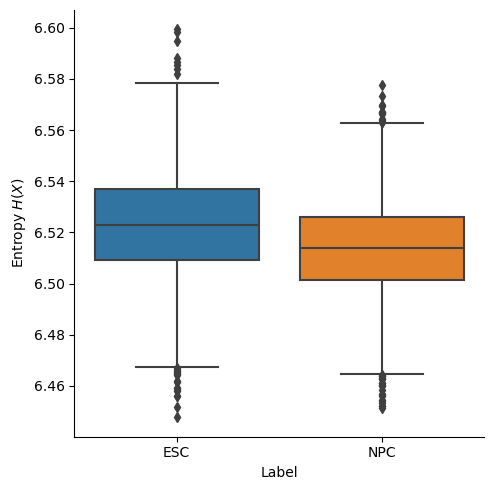

In [91]:
sns.catplot(x='label', y='entropy', data=all_entropy_df, kind='box')
plt.xlabel('Label')
plt.ylabel(r'Entropy $H(X)$')
plt.savefig(os.path.join(save_dir, 'entropy_boxplot_esc_npc.png'), dpi=300, bbox_inches='tight')

In [3]:
# analyze Polychrom vs Polychrom KD 
dataset_path = os.path.join(folder_path, 'fig1Data.mat')
dataset = scipy.io.loadmat(dataset_path)

In [4]:
dataset.keys()

dict_keys(['__header__', '__version__', '__globals__', 'badHybes', 'dataDistMaps', 'dataNames', 'dataPolymers'])

In [5]:
dataset['dataNames']

array([[array(['ESC1 NT 1'], dtype='<U9'),
        array(['ESC PRC KD 1'], dtype='<U12'),
        array(['ESC NT 2'], dtype='<U8'),
        array(['ESC PRC KD 2'], dtype='<U12')]], dtype=object)

In [6]:
dataset['dataPolymers'][0, 0].shape

(54, 3, 597)

In [7]:
bad_hybs = dataset['badHybes']

In [18]:
bad_hybs.shape

(1, 4)

In [8]:
esc_nt_1 = dataset['dataPolymers'][0, 0]
esc_nt_2 = dataset['dataPolymers'][0, 2] 
esc_kd_1 = dataset['dataPolymers'][0, 1]
esc_kd_2 = dataset['dataPolymers'][0, 3]

In [9]:
esc_nt_1[bad_hybs[0, 0], :, :] = np.nan
esc_nt_2[bad_hybs[0, 2], :, :] = np.nan
esc_kd_1[bad_hybs[0, 1], :, :] = np.nan
esc_kd_2[bad_hybs[0, 3], :, :] = np.nan

In [10]:
# Count NaN fraction per cell
def count_nan_fraction(polys):
    return np.sum(np.isnan(polys[:, 1, :]), axis=0) / polys.shape[0]

In [11]:
esc_nt_1_nan = count_nan_fraction(esc_nt_1)
esc_nt_2_nan = count_nan_fraction(esc_nt_2)
esc_kd_1_nan = count_nan_fraction(esc_kd_1)
esc_kd_2_nan = count_nan_fraction(esc_kd_2)

In [12]:
esc_nt_1 = esc_nt_1[:, :, esc_nt_1_nan < 0.8]
esc_nt_2 = esc_nt_2[:, :, esc_nt_2_nan < 0.8]
esc_kd_1 = esc_kd_1[:, :, esc_kd_1_nan < 0.8]
esc_kd_2 = esc_kd_2[:, :, esc_kd_2_nan < 0.8]

In [17]:
esc_nt_1 = interpolate_polymers(esc_nt_1)
esc_nt_2 = interpolate_polymers(esc_nt_2)
esc_kd_1 = interpolate_polymers(esc_kd_1)
esc_kd_2 = interpolate_polymers(esc_kd_2)

In [18]:
esc_nt_1_map = generate_distance_maps(esc_nt_1)
esc_nt_2_map = generate_distance_maps(esc_nt_2)
esc_kd_1_map = generate_distance_maps(esc_kd_1)
esc_kd_2_map = generate_distance_maps(esc_kd_2)

In [19]:
esc_nt_map = np.concatenate([esc_nt_1_map, esc_nt_2_map], axis=0)
esc_kd_map = np.concatenate([esc_kd_1_map, esc_kd_2_map], axis=0)

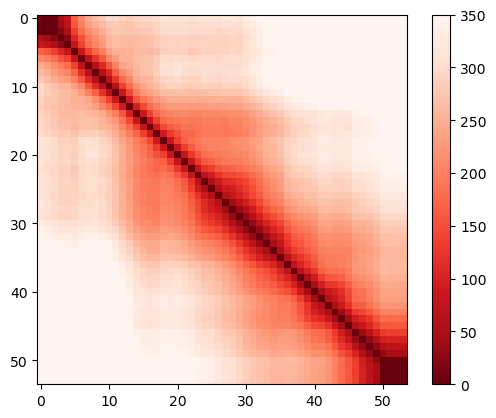

In [65]:
plt.imshow(np.median(esc_nt_map, 0), cmap='Reds_r', vmax=350)
plt.colorbar()

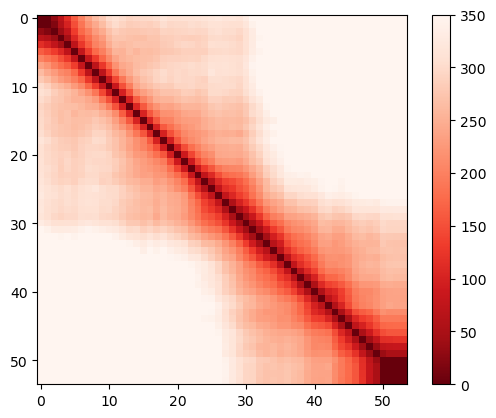

In [68]:
plt.imshow(np.median(esc_kd_map, 0), cmap='Reds_r', vmax=350)
plt.colorbar()

In [20]:
esc_nt_map_flat = np.array([x.flatten() for x in esc_nt_map])
esc_kd_map_flat = np.array([x.flatten() for x in esc_kd_map])

In [21]:
all_map_flat = np.concatenate([esc_nt_map_flat, esc_kd_map_flat], axis=0)

In [22]:
pca = PCA(n_components=2)
pca.fit(all_map_flat)
esc_nt_map_pca = pca.transform(esc_nt_map_flat)
esc_kd_map_pca = pca.transform(esc_kd_map_flat)
# brain_map_pca = pca.transform(brain_map_flat)

In [23]:
# Convert the PC into a dataframe
esc_nt_df = pd.DataFrame(esc_nt_map_pca, columns=['PC1', 'PC2'])
esc_nt_df['label'] = 'NT'
esc_kd_df = pd.DataFrame(esc_kd_map_pca, columns=['PC1', 'PC2'])
esc_kd_df['label'] = 'KD'
# brain_df = pd.DataFrame(brain_map_pca, columns=['PC1', 'PC2'])
# brain_df['label'] = 'Brain'

In [24]:
all_df = pd.concat([esc_nt_df, esc_kd_df], axis=0)

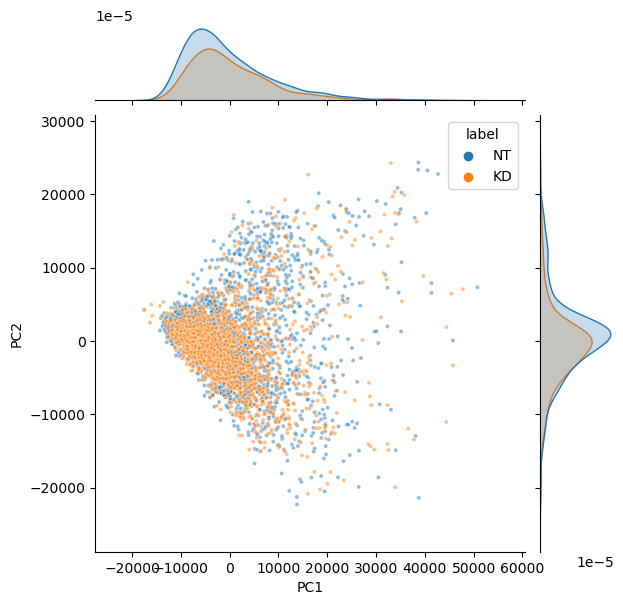

In [25]:
sns.jointplot(x='PC1', y='PC2', data=all_df, marker='.', hue='label', alpha=0.5)

In [52]:
# Find 0.05 and 0.95 quantiles of PC1 and PC2 data
l = 0.01
u = 1-0.01

pc1_l = all_df['PC1'].quantile(l)
pc1_u = all_df['PC1'].quantile(u)
pc2_l = all_df['PC2'].quantile(l)
pc2_u = all_df['PC2'].quantile(u)

pc1_grid = np.linspace(pc1_l, pc1_u, 50)
pc2_grid = np.linspace(pc2_l, pc2_u, 50)

# Generate combination of pc1 and pc2 values
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

# put this into a dataframe
pc1_grid_flat = pc1_grid.flatten()
pc2_grid_flat = pc2_grid.flatten()
pc1_pc2_df = pd.DataFrame({'PC1': pc1_grid_flat, 'PC2': pc2_grid_flat})
pc1_pc2_df['label'] = 'metastructures'

metastr_from_pca = pca.inverse_transform(pc1_pc2_df[['PC1', 'PC2']])

In [26]:
common_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20240823_WeightMCMC_ESC_PC_KD'

stan_directory_kd = os.path.join(common_dir, 'KD/stan_output')
stan_directory_nt = os.path.join(common_dir, 'NT/stan_output')

kd_log_weights = load_weights(stan_directory_kd, 2500)
nt_log_weights = load_weights(stan_directory_nt, 2500)

['20240715_WeightOptimization-20240823161723_1.csv', '20240715_WeightOptimization-20240823161723_2.csv', '20240715_WeightOptimization-20240823161723_3.csv', '20240715_WeightOptimization-20240823161723_4.csv']
['20240715_WeightOptimization-20240823160547_1.csv', '20240715_WeightOptimization-20240823160547_2.csv', '20240715_WeightOptimization-20240823160547_3.csv', '20240715_WeightOptimization-20240823160547_4.csv']


In [28]:
kd_weights_all = np.exp(np.array(kd_log_weights))
nt_weights_all = np.exp(np.array(nt_log_weights))

In [31]:
kd_weights_mean = np.mean(np.exp(np.array(kd_log_weights)), axis=(0, 1))
nt_weights_mean = np.mean(np.exp(np.array(nt_log_weights)), axis=(0, 1))

In [30]:
kd_weights_mean.shape

(2500,)

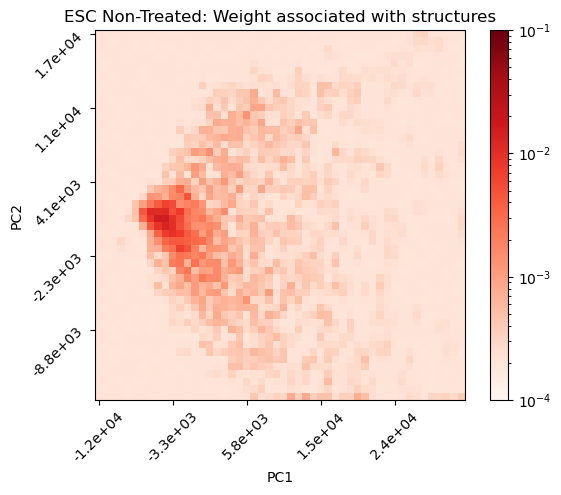

In [36]:
from matplotlib.colors import LogNorm
vmin = 1E-4
vmax = 1E-1

plt.imshow(nt_weights_mean.reshape(50, 50).T,
           cmap='Reds', norm=LogNorm(vmin=vmin, vmax=vmax))
# set xticks 
xlabel = np.array([f"{x:.1e}" for x in np.unique(pc1_pc2_df['PC1'].values)])[::10]
ylabel = np.array([f"{x:.1e}" for x in np.unique(pc1_pc2_df['PC2'].values)])[::-10]
plt.xticks(np.arange(0, 50, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 50, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ESC Non-Treated: Weight associated with structures')
plt.colorbar()
# plt.savefig(os.path.join(save_dir, 'SD_esc_weights_NT_50x50.png'), dpi=300, bbox_inches='tight')


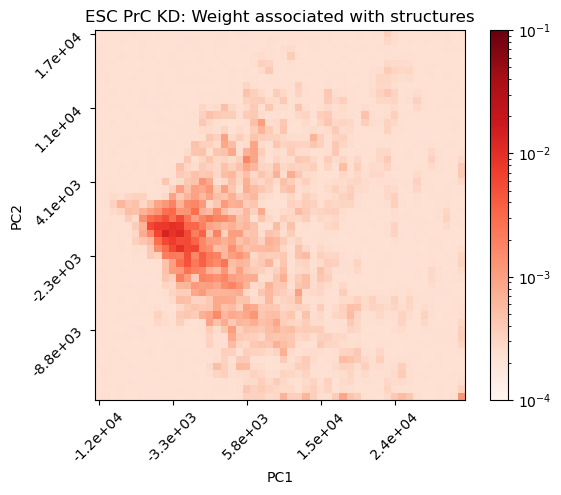

In [37]:
from matplotlib.colors import LogNorm
vmin = 1E-4
vmax = 1E-1

plt.imshow(kd_weights_mean.reshape(50, 50).T,
           cmap='Reds', norm=LogNorm(vmin=vmin, vmax=vmax))
# set xticks 
xlabel = np.array([f"{x:.1e}" for x in np.unique(pc1_pc2_df['PC1'].values)])[::10]
ylabel = np.array([f"{x:.1e}" for x in np.unique(pc1_pc2_df['PC2'].values)])[::-10]
plt.xticks(np.arange(0, 50, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 50, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ESC PrC KD: Weight associated with structures')
plt.colorbar()
# plt.savefig(os.path.join(save_dir, 'SD_esc_weights_NT_50x50.png'), dpi=300, bbox_inches='tight')


In [39]:
nt_weight_table = nt_weights_mean.reshape(50, 50).T
kd_weight_table = kd_weights_mean.reshape(50, 50).T

diff_table = kd_weight_table / nt_weight_table

Text(0.5, 1.0, '$\\ln \\; P_\\mathrm{KD}/P_\\mathrm{NT}$')

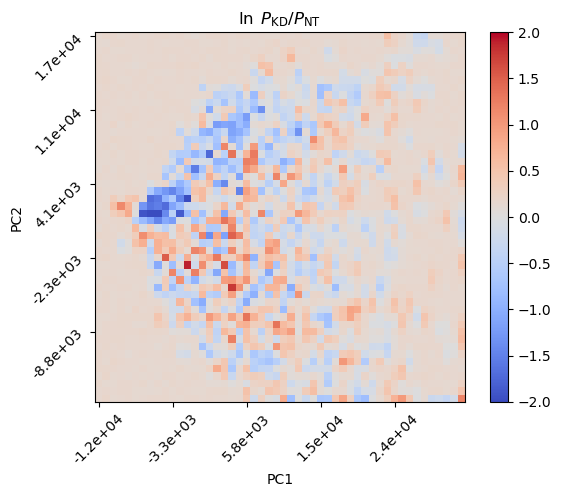

In [43]:
plt.imshow(np.log(diff_table), cmap='coolwarm', vmin=-2, vmax=2)
plt.colorbar()
xlabel = np.array([f"{x:.1e}" for x in np.unique(pc1_pc2_df['PC1'].values)])[::10]
ylabel = np.array([f"{x:.1e}" for x in np.unique(pc1_pc2_df['PC2'].values)])[::-10]
plt.xticks(np.arange(0, 50, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 50, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(r'$\ln \; P_\mathrm{KD}/P_\mathrm{NT}$')
# plt.savefig(os.path.join(save_dir, 'SD_prob_ratio_kd_nt_50x50.png'), dpi=300, bbox_inches='tight')

In [46]:
kd_weights_all = np.exp(np.array(kd_log_weights))
nt_weights_all = np.exp(np.array(nt_log_weights))

kd_weights_all = kd_weights_all.reshape(-1, 2500)
nt_weights_all = nt_weights_all.reshape(-1, 2500)

kd_entropy_all = np.array([scipy.stats.entropy(x) for x in kd_weights_all])
nt_entropy_all = np.array([scipy.stats.entropy(x) for x in nt_weights_all])

# Put these data in dataframe 
kd_entropy_df = pd.DataFrame({'entropy': kd_entropy_all, 'label': 'KD'})
nt_entropy_df = pd.DataFrame({'entropy': nt_entropy_all, 'label': 'NT'})

all_entropy_df = pd.concat([nt_entropy_df, kd_entropy_df], axis=0)

In [47]:
kd_entropy_all.shape

(4000,)

Text(0.5694444444444446, 0.5, 'Entropy $H(X)$')

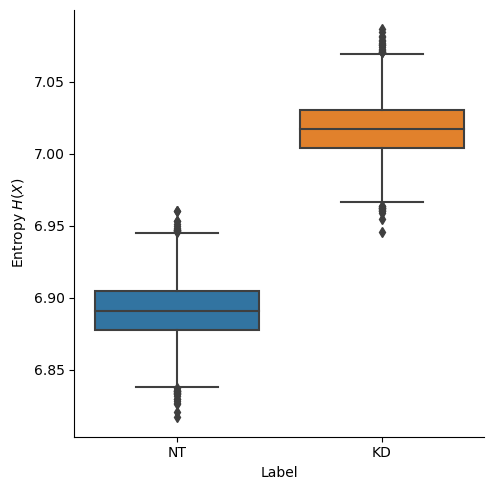

In [49]:
sns.catplot(x='label', y='entropy', data=all_entropy_df, kind='box')
plt.xlabel('Label')
plt.ylabel(r'Entropy $H(X)$')
# plt.savefig(os.path.join(save_dir, 'entropy_boxplot_esc_npc.png'), dpi=300, bbox_inches='tight')

In [50]:
# Flatten the array and get the indices of the top 10 values
flattened_indices = np.argsort(diff_table, axis=None)[-10:]

# Convert the flattened indices back to 2D indices
top_10_indices = np.unravel_index(flattened_indices, diff_table.shape)

# Combine row and column indices into a list of tuples
top_10_indices = list(zip(top_10_indices[0], top_10_indices[1]))

# Flatten the array and get the indices of the top 10 values
flattened_indices = np.argsort(diff_table, axis=None)[:10]

# Convert the flattened indices back to 2D indices
bottom_10_indices = np.unravel_index(flattened_indices, diff_table.shape)

# Combine row and column indices into a list of tuples
bottom_10_indices = list(zip(bottom_10_indices[0], bottom_10_indices[1]))


In [54]:
metastr_dict = {}
for i in range(2500):
    idx = (i%50, i//50)
    metastr = metastr_from_pca[i]
    metastr = metastr.reshape((54, 54))
    metastr_dict[idx] = metastr

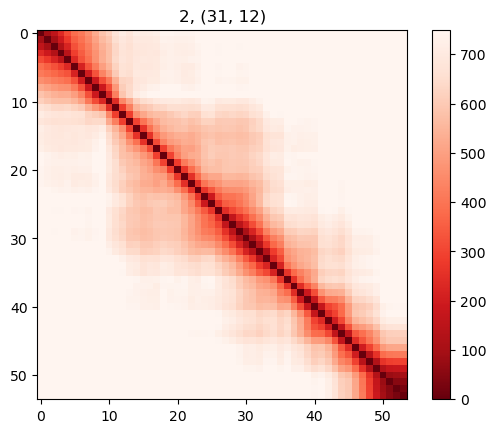

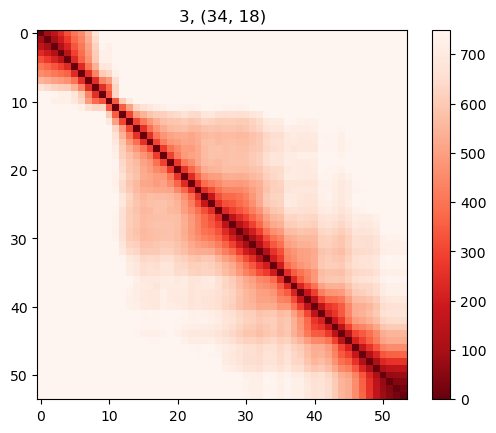

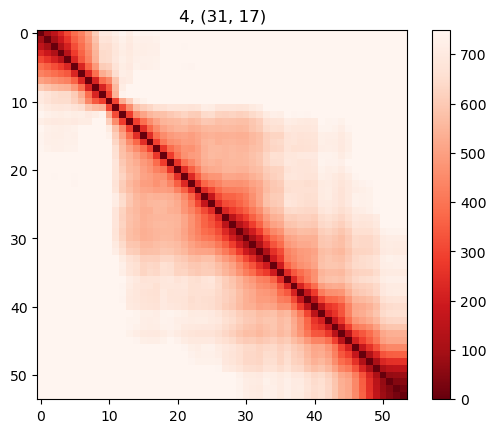

In [74]:
for i in range(1, 4):
    plt.imshow(metastr_dict[top_10_indices[-i]], cmap='Reds_r', vmax=750)
    plt.colorbar()
    plt.title('{}, {}'.format(i+1, top_10_indices[-i]))
    # plt.savefig(os.path.join(save_dir, 'top_{}_metastructure.png'.format(i+1)), dpi=300, bbox_inches='tight')
    plt.show()

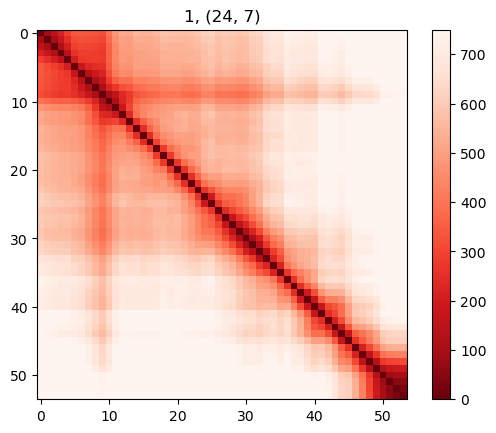

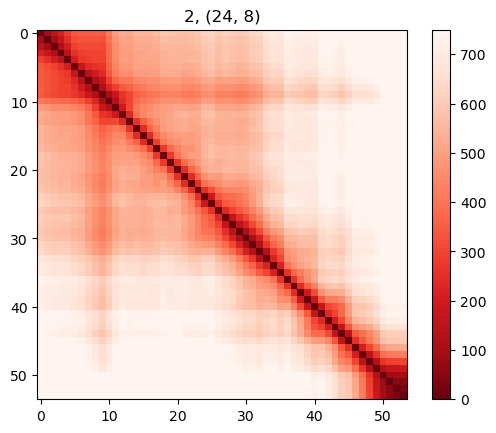

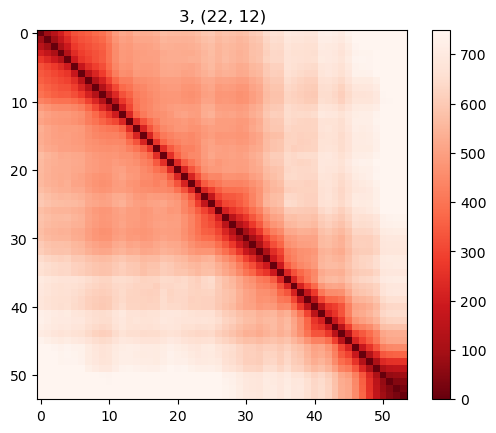

In [73]:
for i in range(3):
    plt.imshow(metastr_dict[bottom_10_indices[i]], cmap='Reds_r', vmax=750)
    plt.colorbar()
    plt.title('{}, {}'.format(i+1, bottom_10_indices[i]))
    # plt.savefig(os.path.join(save_dir, 'bottom_{}_metastructure.png'.format(i+1)), dpi=300, bbox_inches='tight')
    plt.show()

In [75]:
import numpy as np

def reconstruct_coordinates_from_edm(D):
    # Step 1: Convert distance matrix to squared distance matrix
    D2 = D ** 2
    
    # Step 2: Centering matrix
    n = D.shape[0]
    J = np.eye(n) - np.ones((n, n)) / n
    
    # Step 3: Compute Gram matrix
    B = -0.5 * J @ D2 @ J
    
    # Step 4: Eigenvalue decomposition
    eigvals, eigvecs = np.linalg.eigh(B)
    
    # Step 5: Select top 3 eigenvalues and corresponding eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    
    # Select the top 3 eigenvalues and their corresponding eigenvectors
    L = np.diag(np.sqrt(eigvals[:3]))
    V = eigvecs[:, :3]
    
    # Step 6: Construct the coordinates
    X = V @ L
    
    return X

In [81]:
# Example usage with a dummy distance matrix D
x1 = [0, 0, 1]
x2 = [1, 0, 0] 
x3 = [0, 1, 1]
x = np.array([x1, x2, x3])
D = squareform(pdist(x))

coordinates = reconstruct_coordinates_from_edm(D)
print(coordinates)


[[ 2.65408406e-01  5.12729667e-01  3.91742909e-09]
 [-9.90517655e-01 -1.37385500e-01  3.91742909e-09]
 [ 7.25109249e-01 -3.75344167e-01  3.91742909e-09]]


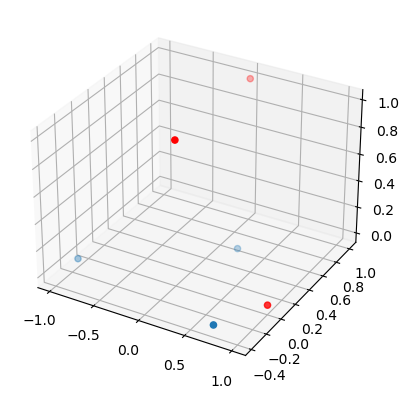

In [83]:
# plot 3d coordinates 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2])
ax.scatter(x[:, 0], x[:, 1], x[:, 2], color='red')